# Fiddle with the EAWAG scans
Look at the orientation and see if we can do some cropping based on landmarks.

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client, LocalCluster
import skimage
from tqdm.auto import tqdm, trange
import math

/home/habi/miniconda3/envs/eawag/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to /media/habi/Fast_SSD/tmp


In [3]:
# Start cluster and client now, after setting tempdir
cluster = LocalCluster()
client = Client(cluster)

In [4]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [5]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [6]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (8, 4.5)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200

In [7]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [8]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

In [9]:
# Different locations if running either on Linux or Windows
FastSSD = True
overthere = False # Load the data directly from the iee-research_storage drive
nanoct = True # Load the data directly from the 2214
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    elif overthere:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'research-storage-iee')
    elif nanoct:
        BasePath = os.path.join(os.path.sep, 'home', 'habi', '2214')                
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    FastSSD = False
    BasePath = os.path.join('/Users/habi/Dev/EAWAG/Data')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
if not overthere:
    Root = os.path.join(BasePath, 'EAWAG')
else:
    Root = BasePath
# if overthere:
#         Root = os.path.join('I:\\microCTupload')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/EAWAG


In [10]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [11]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [12]:
# # Make directory for output
# OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
# print('We are saving all the output to %s' % OutPutDir)
# os.makedirs(OutPutDir, exist_ok=True)

In [13]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [14]:
# Get *all* log files
# Sort them by time, not name
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True), key=os.path.getmtime)]

In [15]:
# Generate folder name
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [16]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)        
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [17]:
# Generate us some meaningful colums
Data['Fish'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['_'.join(l[len(Root)+1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [18]:
Data.tail()

,LogFile,Folder,Fish,Scan
335,/media/habi/Fast_SSD/EAWAG/ZU12/rec_reconstruc...,/media/habi/Fast_SSD/EAWAG/ZU12/rec_reconstruct,ZU12,rec_reconstruct
336,/media/habi/Fast_SSD/EAWAG/ZuOS115/head/rec/Zu...,/media/habi/Fast_SSD/EAWAG/ZuOS115/head/rec,ZuOS115,head_rec
337,/media/habi/Fast_SSD/EAWAG/ZuOS115/rec/ZuOS115...,/media/habi/Fast_SSD/EAWAG/ZuOS115/rec,ZuOS115,rec
338,/media/habi/Fast_SSD/EAWAG/ZuOS115/rec_oj/ZuOS...,/media/habi/Fast_SSD/EAWAG/ZuOS115/rec_oj,ZuOS115,rec_oj
339,/media/habi/Fast_SSD/EAWAG/ZuOS148/rec/ZuOS148...,/media/habi/Fast_SSD/EAWAG/ZuOS148/rec,ZuOS148,rec


In [19]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [20]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
# `find . -name "*rec*.png" -type f -mtime +333 -delete`
# Based on https://stackoverflow.com/a/13851602
# for c,row in Data.iterrows():
#     if not row['Number of reconstructions']:
#         print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

We have 8 folders with reconstructions


In [33]:
# Get parameters we need from the log files
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [34]:
Data.tail()

,LogFile,Folder,Fish,Scan,Reconstructions,Number of reconstructions,Voxelsize
3,/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec/...,/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec,BucketOfFish_A,rec,[/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec...,1713,34.999866
4,/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec_...,/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec_...,BucketOfFish_A,rec_10576,[/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec...,1713,34.999866
5,/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec_...,/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec_...,BucketOfFish_A,rec_13420,[/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec...,1713,34.999866
6,/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec_...,/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec_...,BucketOfFish_A,rec_161543,[/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec...,1713,34.999866
7,/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec_...,/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec_...,BucketOfFish_A,rec_BI10,[/media/habi/Fast_SSD/EAWAG/BucketOfFish_A/rec...,1713,34.999866


In [35]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, '*_spr.bmp')))[0] for f in Data['Folder']]
Data['PreviewImage'] = [dask_image.imread.imread(pip).squeeze()
                        if pip
                        else numpy.random.random((100, 100)) for pip in Data['PreviewImagePath']]

In [42]:
# Make an approximately square overview image
lines = 2

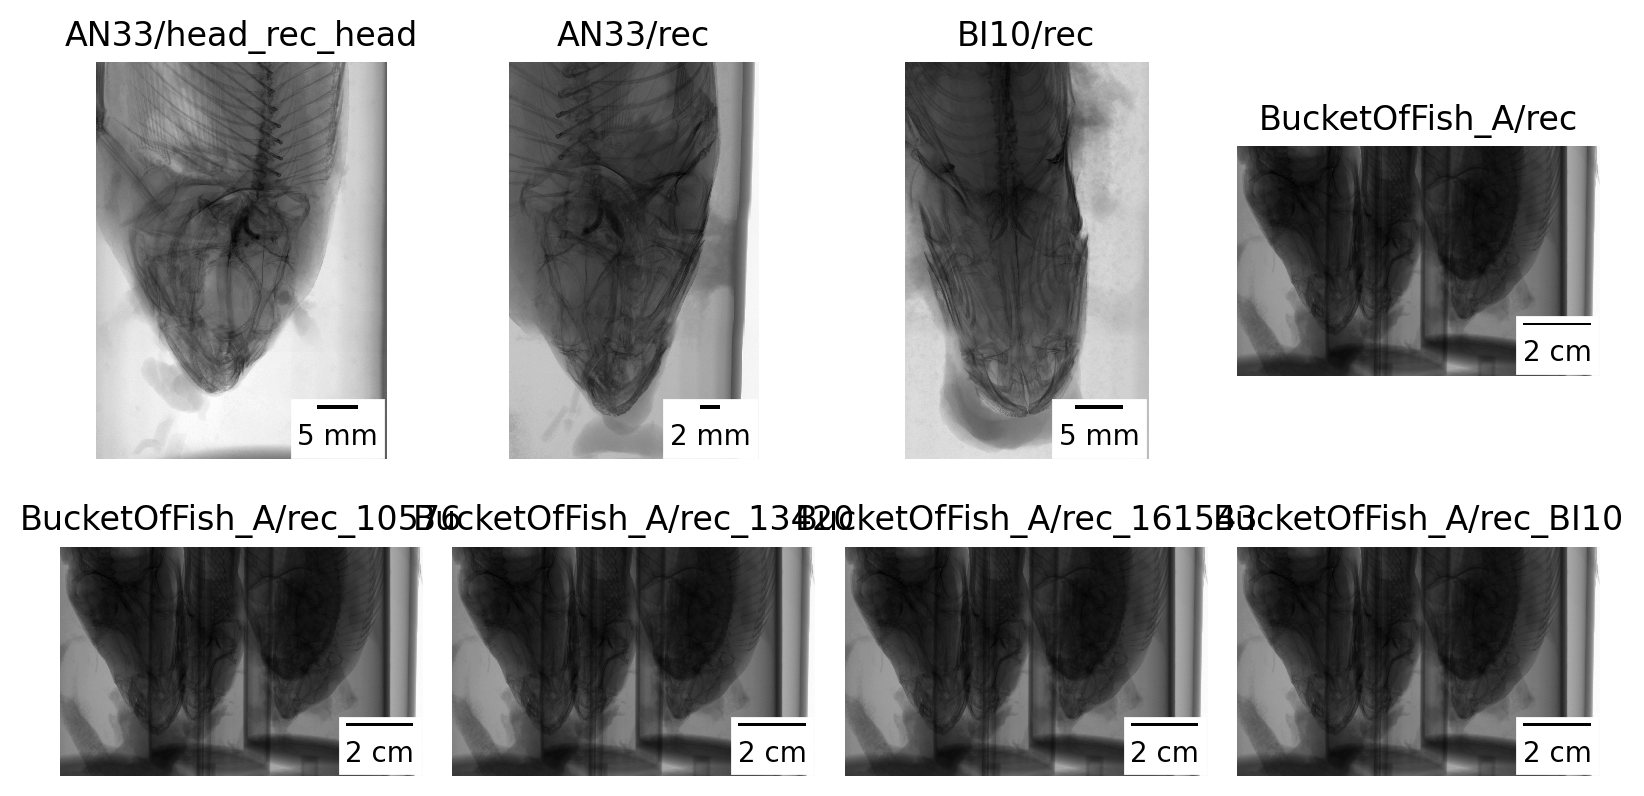

In [43]:
for c, row in Data.iterrows():
    plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
    plt.imshow(row.PreviewImage.squeeze())
    plt.title(os.path.join(row['Fish'], row['Scan']))
    plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                  'um',
                                  color='black',
                                  frameon=True))
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(Root, 'ScanOverviews.png'),
            bbox_inches='tight')
plt.show()

In [38]:
# Load all reconstructions as DASK arrays
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Load reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
                                                               '*rec*.png'))

Load reconstructions:   0%|          | 0/8 [00:00<?, ?it/s]

In [44]:
# Check if something went wrong
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [45]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [46]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [47]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(), desc='MIPs', total=len(Data), leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Fish'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Fish'],
                                                      row['Scan'],
                                                      direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

MIPs:   0%|          | 0/8 [00:00<?, ?it/s]

AN33/head_rec_head:   0%|          | 0/3 [00:00<?, ?it/s]

AN33/rec:   0%|          | 0/3 [00:00<?, ?it/s]

BI10/rec:   0%|          | 0/3 [00:00<?, ?it/s]

BucketOfFish_A/rec:   0%|          | 0/3 [00:00<?, ?it/s]

BucketOfFish_A/rec_10576:   0%|          | 0/3 [00:00<?, ?it/s]

BucketOfFish_A/rec_13420:   0%|          | 0/3 [00:00<?, ?it/s]

BucketOfFish_A/rec_161543:   0%|          | 0/3 [00:00<?, ?it/s]

BucketOfFish_A/rec_BI10:   0%|          | 0/3 [00:00<?, ?it/s]

Saving MIP images overview:   0%|          | 0/8 [00:00<?, ?it/s]

AN33/head_rec_head:   0%|          | 0/3 [00:00<?, ?it/s]

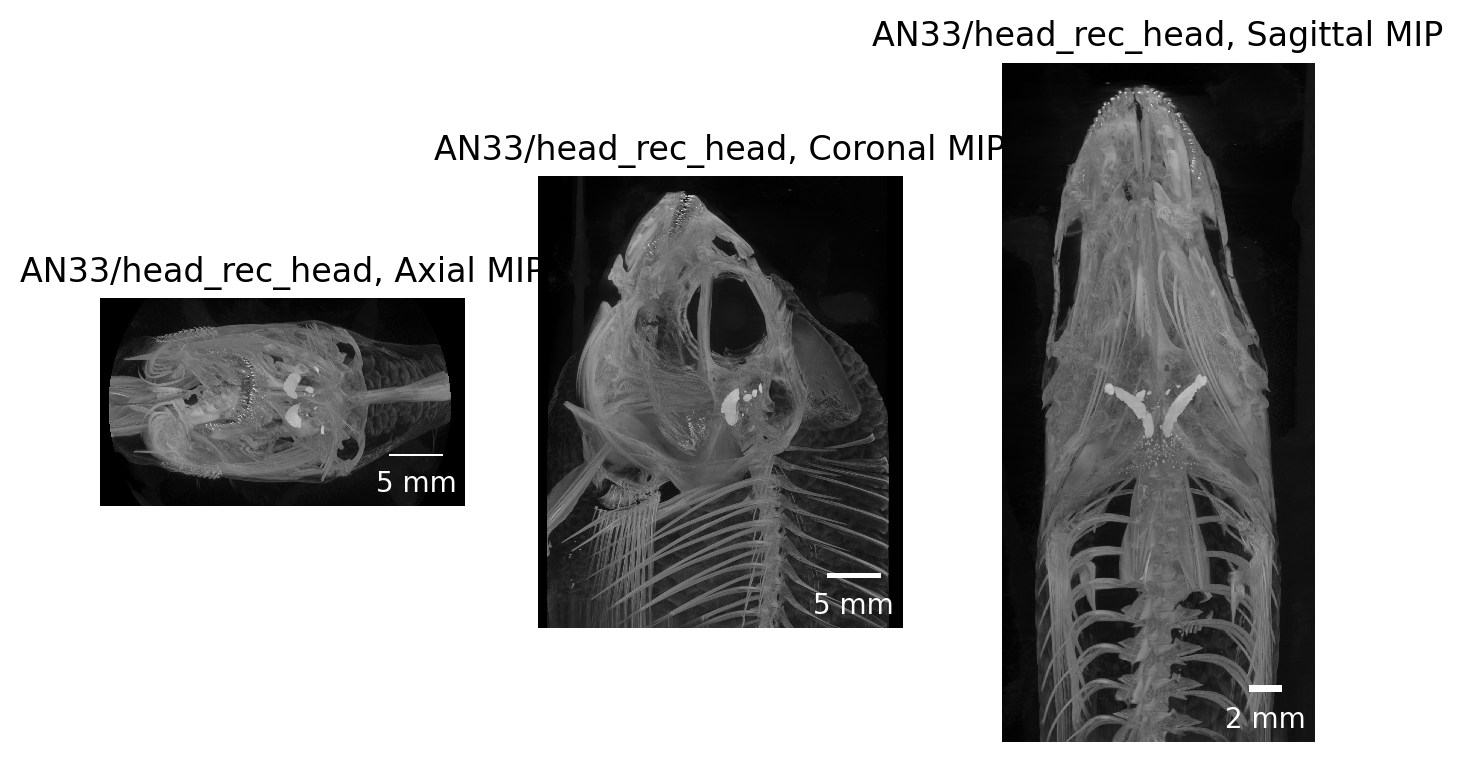

AN33/rec:   0%|          | 0/3 [00:00<?, ?it/s]

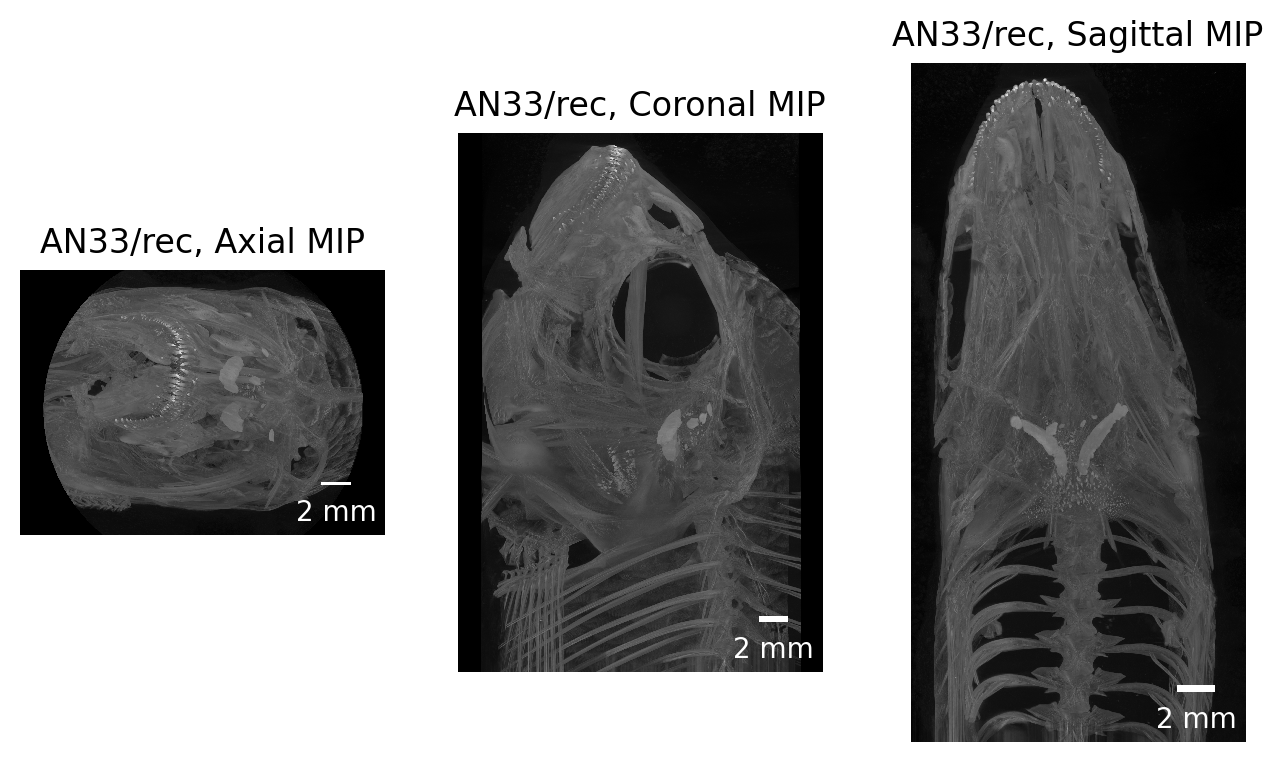

In [48]:
# Show MIP slices
for c, row in tqdm(Data.iterrows(),
                   desc='Saving MIP images overview',
                   total=len(Data),
                   leave=False):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MIPs.png' % (row['Fish'], row['Scan']))
    if not os.path.exists(outfilepath):    
        for d, direction in tqdm(enumerate(directions),
                                          desc='%s/%s' % (row['Fish'], row['Scan']),
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction].squeeze())
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um'))
            plt.title('%s, %s' % (os.path.join(row['Fish'], row['Scan']),
                                  direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outfilepath,
                    transparent=True,
                    bbox_inches='tight')
        plt.show()

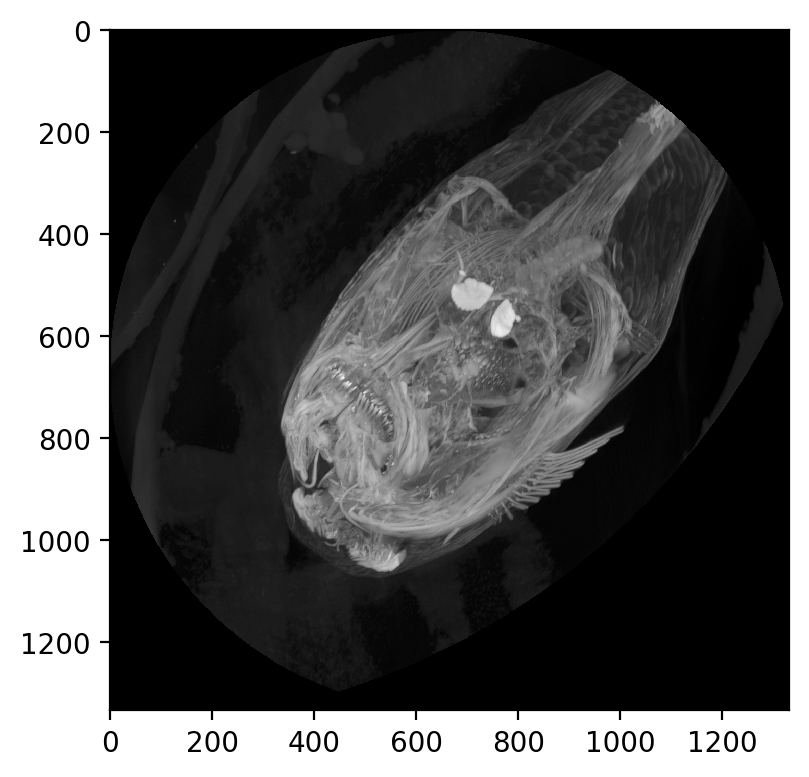

In [53]:
# load one axial MIP into an image for fiddling with it
img = Data.MIP_Axial[4].squeeze()
plt.imshow(img)
plt.show()

The functions below were copied from Hearts-Melly/SubMyocardAnalysis.ipynb, in which we also look at the orientation of things

In [54]:
# From Hearts-Melly/SubMyocardAnalysis.ipynb
def get_properties(roi, verbose=False):
    # Label filled image
    labeled_img = skimage.measure.label(roi)
    # Extract regionprops of image and put data into pandas
    # https://stackoverflow.com/a/66632023/323100
    props = skimage.measure.regionprops_table(labeled_img,
                                              properties=('label',
                                                          'centroid',
                                                          'area',
                                                          'perimeter',
                                                          'orientation'))
    table = pandas.DataFrame(props)
    table_sorted = table.sort_values(by='area', ascending=False)
    # return only the region with the biggest area
    properties = table_sorted.iloc[:1].reset_index()
    if verbose:
        plt.imshow(roi, alpha=0.5)
        plt.title('Original')
        plt.axis('off')
        plt.imshow(numpy.ma.masked_equal(labeled_img, 0), cmap='viridis', alpha=0.5)
        plt.title('Labelled')
        plt.axis('off')
        plt.show()
    return(properties)

In [55]:
def get_largest_region(segmentation, verbose=False):
    # Get out biggest item from https://stackoverflow.com/a/55110923/323100
    labels = skimage.measure.label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == numpy.argmax(numpy.bincount(labels.flat)[1:])+1
    if verbose:
        plt.subplot(121)
        plt.imshow(segmentation)
        plt.subplot(122)
        plt.imshow(largestCC)
        plt.suptitle('Largest connected component')
        plt.show()
    return largestCC

In [57]:
def threshold(image, verbose=False):
    threshold = skimage.filters.threshold_otsu(img)
    if verbose:
        plt.subplot(121)
        plt.imshow(img)
        plt.imshow(dask.array.ma.masked_equal(img>threshold,0),
                   alpha=0.618,
                   cmap='viridis_r')
        plt.subplot(122)
        plt.semilogy(histogram(img), label='Log-Histogram')
        plt.axvline(threshold, label='Otsu threshold: %s' % threshold)
        plt.legend()
        plt.show()
    return(threshold)

In [58]:
# Calculate the histogram of an image
# We bluntly assume 8bit images
def histogram(img):
    histogram, bins = dask.array.histogram(dask.array.array(img.squeeze()),
                                           bins=2**8,
                                           range=[0, 2**8])
    return(histogram)

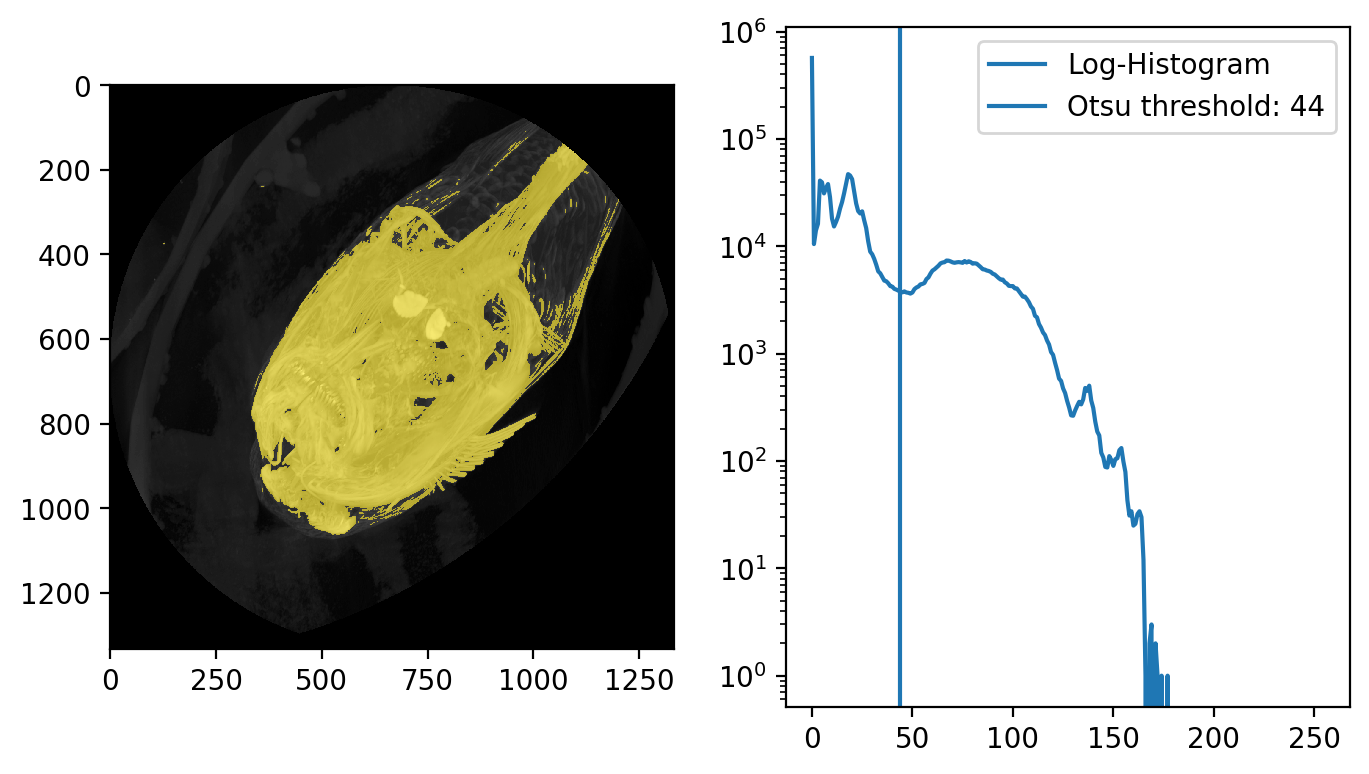

In [59]:
t = threshold(img, verbose=True)

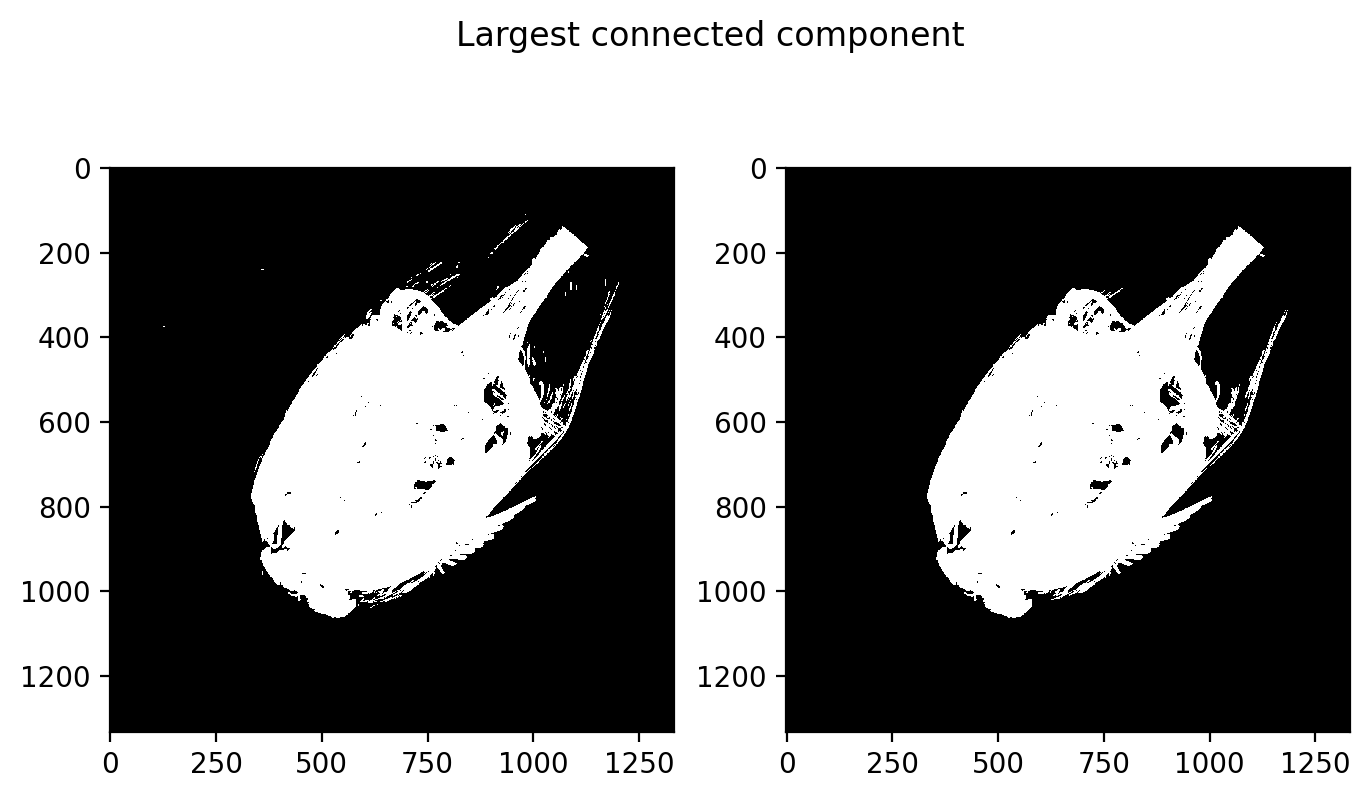

In [60]:
a = get_largest_region(img>t, verbose=True)

In [61]:
def get_centroid(img, verbose=False):
    props = get_properties(img)
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
    y0, x0 = props['centroid-0'], props['centroid-1']
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        plt.axis('off')
        plt.show()
    return((x0,y0))

In [ ]:
def get_contour(filled_img, verbose=False):
    # Contouring from https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html
    largest_region = get_largest_region(filled_img, verbose=False)
    contour = skimage.measure.find_contours(largest_region)
    # Even though we look only at the largest region, we still might get out more than one contour
    # Let's thus sort the list and just continue with the longest one 
    (contour).sort(key=len)
    cy, cx = contour[-1].T
    if verbose:
        plt.imshow(filled_img)
        plt.plot(cx, cy, lw=1, c='r')
        plt.axis('off')
        plt.show()
    return(cx, cy)

In [ ]:
contour = get_contour(img>t, verbose=True)

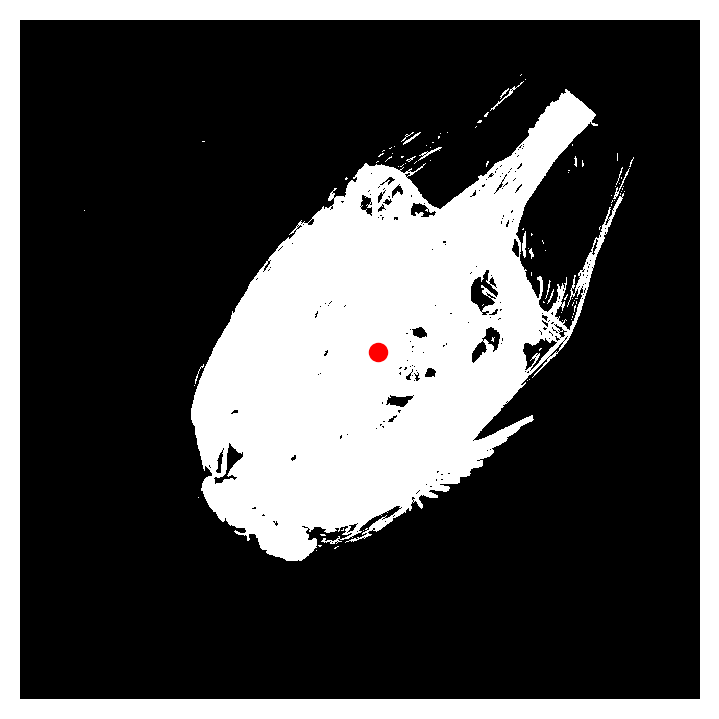

In [62]:
centroid = get_centroid(img>t, verbose=True)

In [63]:
def draw_orientation(img, x0, x1, x2, y0, y1, y2, self=False):
    if self:
        plt.imshow(img)
    plt.plot((x0, x1), (y0, y1), '-r', linewidth=1)
    plt.plot((x0, x2), (y0, y2), '-r', linewidth=1)
    if self:
        plt.axis('off')
        plt.show()
    return()

In [64]:
def get_orientation(img, voxelsize, length=5000, verbose=False):
    props = get_properties(img)
    whichlengthdowewant = length
    reallength= whichlengthdowewant / voxelsize # um
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.htm
    x0, y0 = get_centroid(img)
    x1 = x0 + math.cos(props['orientation']) * reallength
    y1 = y0 - math.sin(props['orientation']) * reallength
    x2 = x0 - math.sin(props['orientation']) * reallength
    y2 = y0 - math.cos(props['orientation']) * reallength
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        draw_orientation(img, x0, x1, x2, y0, y1, y2)
        plt.gca().add_artist(ScaleBar(voxelsize, 'um'))
        plt.title('Image with %s um long orientation bars' % length)
        plt.axis('off')
        plt.show()
    return(x0,x1,x2,y0,y1,y2)

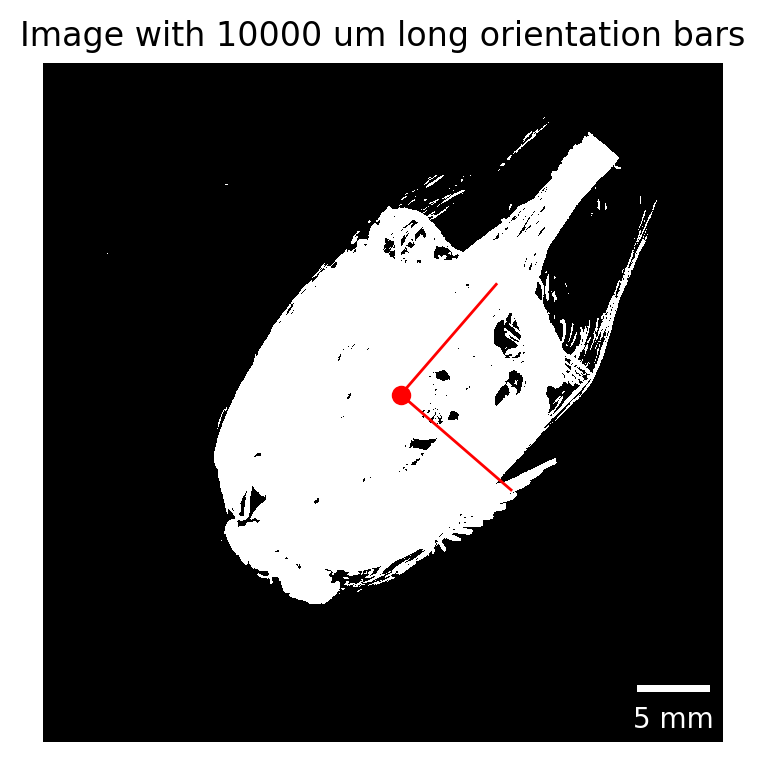

In [128]:
x0,x1,x2,y0,y1,y2 = get_orientation(img>t,
                                    Data.Voxelsize[4],
                                    length=10000,
                                    verbose=True)

The functions above were copied from Hearts-Melly/SubMyocardAnalysis.ipynb, in which we also look at the orientation of things

In [130]:
a = get_properties(img>t)
print(a)

   index  label  centroid-0  centroid-1    area     perimeter  orientation
0      5      6  650.398879  701.082497  375966  12763.519651    -0.713333


In [188]:
# Use the angle and centroid to rotate image
img_rotated = numpy.empty_like(img)
img_rotated = skimage.transform.rotate(img.compute(),
                                       angle=numpy.rad2deg(a.orientation[0]),
                                       center=(a['centroid-0'][0],a['centroid-1'][0]),
                                       preserve_range=True)

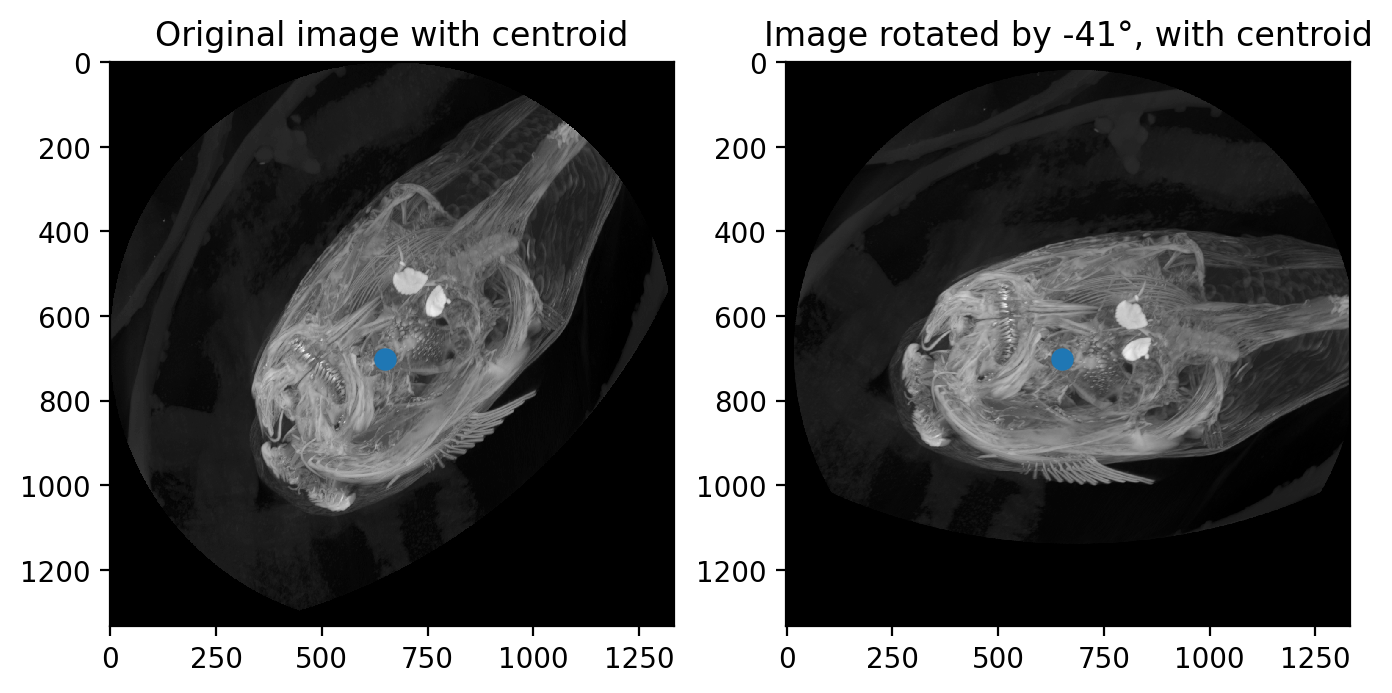

In [189]:
# Let's show what we did
plt.subplot(121)
plt.imshow(img)
plt.scatter(a['centroid-0'],a['centroid-1'], s=50)
plt.title('Original image with centroid')
plt.subplot(122)
plt.imshow(img_rotated)
plt.scatter(a['centroid-0'],a['centroid-1'], s=50)
plt.title('Image rotated by %0.f°, with centroid' % numpy.rad2deg(a.orientation[0]))
plt.show()

In [190]:
center=a.orientation[0]

In [191]:
center

-0.7133329332739843

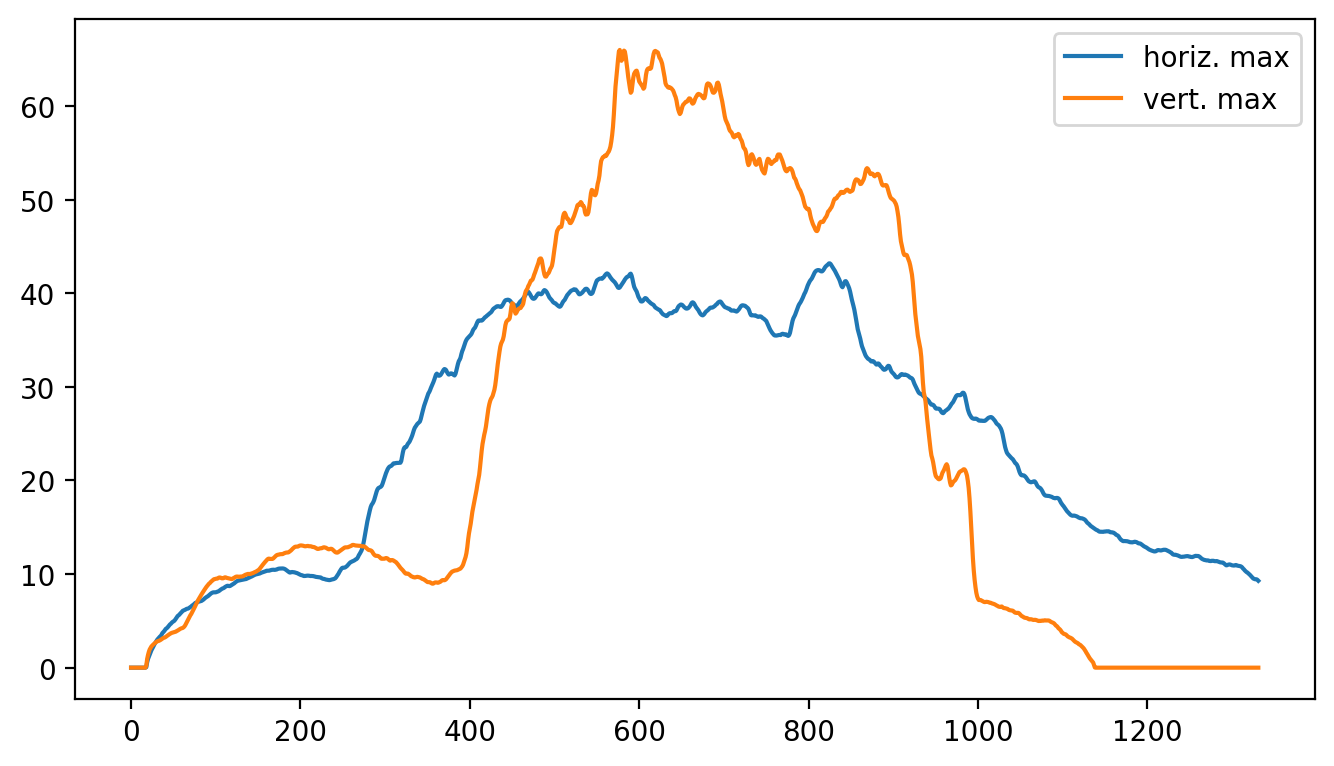

In [195]:
# Can we separate the otoliths?
plt.plot(img_rotated.mean(axis=0), label='horiz. max')
plt.plot(img_rotated.mean(axis=1), label='vert. max')
plt.legend()
plt.show()

In [242]:
# Find peaks
# Try to find wide ones higher than the threshold we calculated before
peaks, _ = scipy.signal.find_peaks(img_rotated.mean(axis=1),
                                   height=t,
                                   width=10)

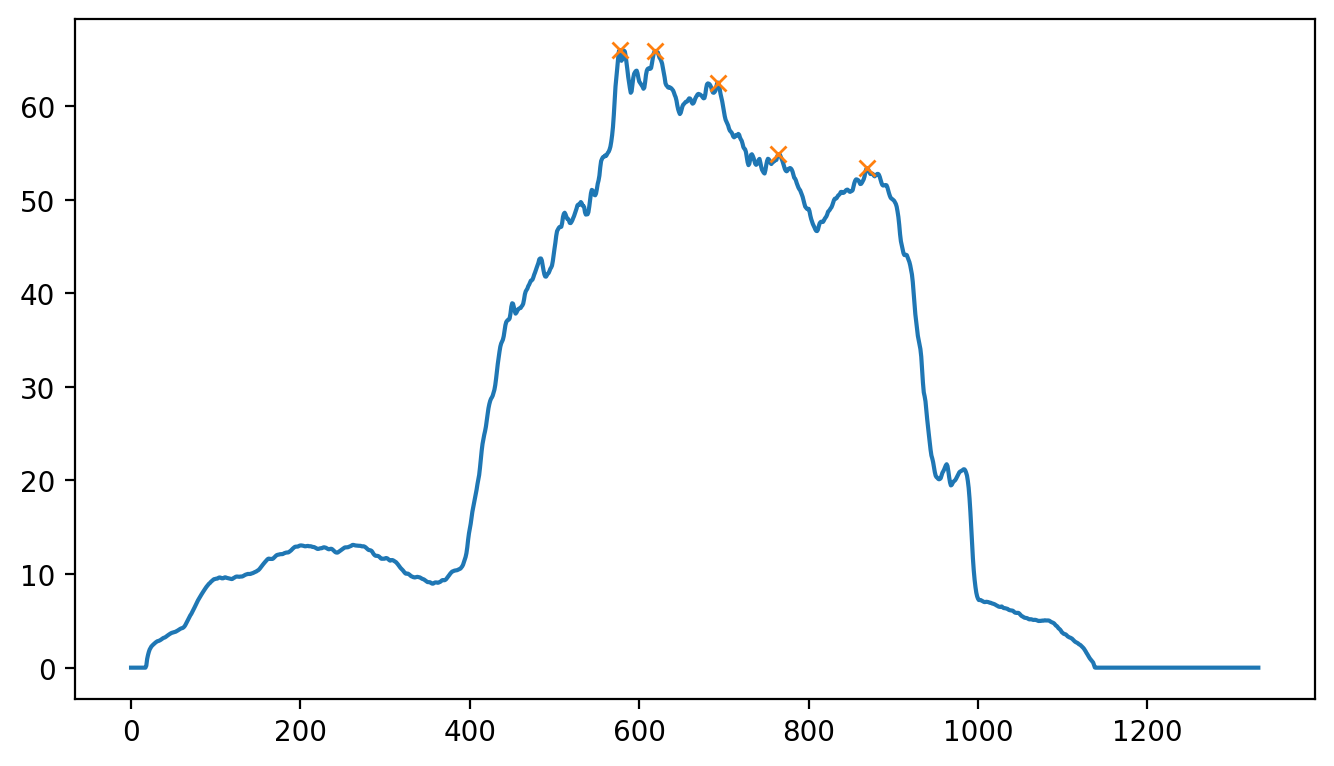

In [243]:
# Plot the peaks we found
plt.plot(img_rotated.mean(axis=1), label='vert. max')
plt.plot(peaks, img_rotated.mean(axis=1)[peaks], "x")
plt.show()